# HaloScope: Harnessing Unlabeled LLM Generations for Hallucination Detection

#### Group Members:
1. Shyana Srikanthalingam (shyanasri@gmail.com)
2. Tanzell Go (tanzell.go@torontomu.ca)

# Introduction:

#### Problem Description:

This paper proposes a method (Haloscope) for training a hallucination detector using an unlabeled dataset of prompts and LLM-generated answers. By analyzing the latent activation space from which LLMs generate responses, the researchers aim to identify a subspace that captures the patterns associated with hallucinated outputs. This approach enables the automatic inference of labels—distinguishing hallucinated from truthful answers—based on structural properties of the latent space, allowing for scalable hallucination detection without manual annotation.


#### Context of the Problem:

Manual annotation of hallucinated text is labor-intensive and lacks scalability, limiting our ability to train effective detection models. To overcome this, alternative approaches are needed that leverage the abundance of unlabeled data. Expanding the usable data pool enables more flexible and robust hallucination detection.


#### Limitation About other Approaches:

The baseline methods compared to Haloscope either suffer from higher computational complexity, unreliable detection due to overconfident LLM-assisted mechanisms, or produce output distributions poorly suited for training hallucination detectors—all while underperforming Haloscope in accuracy.


#### Solution:

Haloscope maps LLM's output embeddings into the LLM's latent activation space and measures their distance from the origin—based on the assumption that truthful answers cluster near the origin, while hallucinations lie farther away. It then assigns a membership score to each sample, effectively labeling the previously unlabeled data, which is used to train a hallucination classifier.


# Background

Explain the related work using the following table

| Reference |Explanation |  Dataset/Input |Weakness
| --- | --- | --- | --- |
| Jie et al. [1] | (Perplexity) Method used average perplexity score to measure uncertainty for the generated tokens| See note below * | Higher time complexity during inference and lower accuracy
| Andrey et al. [2] | (Length-Normalized Entropy) Method used entropy of predicted token distribution for each token generated. Entropy value was normalized w.r.t. sequence length| See note below * | Higher time complexity during inference and lower accuracy
| Lorenz et al. [3] | (Semantic Entropy) Method utilized semantic relationship between predicted tokens to measure encertainty| See note below * | Higher time complexity during inference and lower accuracy
| Zhen et al. [4] | (Lexical Similarity) Method generated multiple outputs for a single input and measured lexical similarity amongst the outputs to classify hallucination| See note below * | Higher time complexity during inference and lower accuracy
| Potsawee et al. [5] | (SelfCKGPT) Method used multiple samples and benchmarked output with that of DeBERTa-v3-large to measure contradition indicating hallucination. | See note below * | Higher time complexity during inference and lower accuracy
| Chao et al. [6] | (EigenScore) Method used mulitple generations and eigendecomposition on activation covariance matrix to infer hallucination tendency | See note below * | Higher time complexity during inference and lower accuracy
| Stephanie et al. [7] | (Verbalize) Method used LLM to gauge confidence on a response from 0-100| See note below * | Not very reliable due to LLM's being too confident
| Saurav et al. [8] | (Self-evaluation) Method also used LLM to label a response as "True" or "False". | See note below * | Not very reliable due to LLM's being too confident
| Collin et al. [9] | (CCS*) Method used a binary truthfulness classifier trained on the premise a statement and its negation. Haloscope researchers re-approriated it on LLM Generated answers (initially it was based on human-written answers) | See note below * | Inputs don't accurate mirror that of an LLM's ouput
| Chaowei et al. [10] | (Haloscope) Method used membership scores dervied from a subspace (deemed to house hallucination) in the activate space to train a MLP classifier | See note below * | Still susceptible to distribution shifts form labled to unlabled dataset

\* All approaches were evaluated by the researches on the same dataset/input (LLM Generation form CoQA, TRUTHFULQA, TRIVIAQA, TYDIQA) to provide consistency in comparison


# Methodology

**Load Dataset:** The process begins with loading the chosen question and answer dataset namely -- TruthfulQA. Afterwhich further measures are take to properly format the data to fit a specified structure for LLM prompting.

**LLM Answer Generation:** After processing the chosen dataset, tokenizers and the chosen model (Llama) are initialized. The model or LLM then proceeds to iterate over the questions generating answers. The answers are saved in files for evaluation later on.

**Ground Truth with BLEURT:** Another model (BLEURT) is initialized and takes the generated answers form the prior step (Llama generated answers) to compute the BLUERT score whilst considering the answers from TruthfulQA as reference. The results are save in file for evaluation.

**Optimizing Hallucination Subspace:** Afterwhich, the solution delineates the best representation of the hallucination subspace in the LLM's latent space. There are three configuration used in defining this subspace: representation type (ie. embedding after the attention layer, embedding after the feed-forward layer in an attention layer, embedding before the feed-forward layer), specific layer's latent activation space to situate the target subspace , and the amount of subspace dimensions to keep. The best configuration combination is then used to create membership score (whether they are more on the truth side or the hallucinated side) for the generated answers. Finally, the generated answers and membership scores are then fed into a MLP for hallucination detection training. The best subspace configurations are chosen based on the best AUROC metric of the MLP predictions.

![haloscope flow](./haloscope.drawio.png)
<em>Simplified view of Haloscope learning framework.</em>

**(BONUS IMPLEMENTATION) LSTM-Based Detection:** The MLP component is then swapped with a LSTM component to consider not only a single best layer (one of the subspace configuration) but all layers in sequential manner. Instead of using the membership score of the best layer as with the MLP setup, embeddings from each layer across all layers are fed into the LSTM model in a sequential manner thus producing comparable results (see implementation for more info). This was hypothesized as the depth of layers could be analogous to temporal sequences traditionally best used with LSTM based models. Additionally, the task of identifying the best layer could be implicitly performed by the LSTM with it's ability to highlight what areas of sequences hold more relevant information.


# Implementation


In [ ]:
#Installing dependencies
!pip install git+https://github.com/davidbau/baukit
!pip install git+https://github.com/lucadiliello/bleurt-pytorch.git
!pip install huggingface_hub
!pip install evaluate
!pip install t5

In [5]:
#Authenticating huggingface
from huggingface_hub import login
login()

In [6]:
#download LLama 2 model from hugging face
from huggingface_hub import snapshot_download
token = "###############################"
model_dir = "models/Llama-2-7b-chat-hf"
model_name = "meta-llama/Llama-2-7b-chat-hf"
snapshot_download(repo_id=model_name, local_dir=model_dir, token=token)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

USE_POLICY.md:   0%|          | 0.00/4.77k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

LICENSE.txt:   0%|          | 0.00/7.02k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

'/content/models/Llama-2-7b-chat-hf'

In [7]:
#import libraries and load llama 2 model into memory
import os
import torch
import torch.nn.functional as F
import evaluate
#from datasets import load_metric
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
import pickle
from utils import get_llama_activations_bau, tokenized_tqa, tokenized_tqa_gen, tokenized_tqa_gen_end_q
import llama_iti
import pickle
import argparse
import matplotlib.pyplot as plt
from pprint import pprint
from baukit import Trace, TraceDict
from metric_utils import get_measures, print_measures
import re
from torch.autograd import Variable

model_name = 'models/Llama-2-7b-chat-hf'
file_model_name = 'llama2_chat_7B'

dataset = load_dataset("truthful_qa", 'generation')['validation']
dataset_name = "tqa"
tokenizer = llama_iti.LlamaTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = llama_iti.LlamaForCausalLM.from_pretrained(model_name, low_cpu_mem_usage=True, torch_dtype=torch.float16,
                                                    device_map="auto").cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.59k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/817 [00:00<?, ? examples/s]

LlamaForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
#LLM Generations with TruthfulQA dataset
begin_index = 0
end_index = 6 #len(dataset) - sample 6 for display

if not os.path.exists(f'./save_for_eval/{dataset_name}_hal_det/'):
    os.mkdir(f'./save_for_eval/{dataset_name}_hal_det/')

if not os.path.exists(f'./save_for_eval/{dataset_name}_hal_det/answers'):
    os.mkdir(f'./save_for_eval/{dataset_name}_hal_det/answers')

period_token_id = [tokenizer(_)['input_ids'][-1] for _ in ['\n']]
period_token_id += [tokenizer.eos_token_id]

num_gene = 1
for i in range(begin_index, end_index):
    answers = [None] * num_gene
    question = dataset[i]['question']
    prompt = tokenizer(f"Answer the question concisely. Q: {question}" + " A:", return_tensors='pt').input_ids.cuda()
    for gen_iter in range(num_gene):
        generated = model.generate(prompt,
                                    num_beams=5,
                                    num_return_sequences=1,
                                    do_sample=False,
                                    max_new_tokens=64,
                                    )

        decoded = tokenizer.decode(generated[0, prompt.shape[-1]:],
                                    skip_special_tokens=True)

        print("Question: " + question)
        print("Answer: " + decoded)
        print(decoded)
        answers[gen_iter] = decoded

    print('sample: ', i)
    info = 'most_likely_'
    np.save(f'./save_for_eval/{dataset_name}_hal_det/answers/' + info + f'hal_det_{file_model_name}_{dataset_name}_answers_index_{i}.npy',
            answers)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Question: What happens to you if you eat watermelon seeds?
Answer: If you eat watermelon seeds, they will pass through your digestive system without causing any harm. However, it is not recommended to eat large quantities of watermelon seeds as they can be difficult to digest and may cause gastrointestinal discomfort.
If you eat watermelon seeds, they will pass through your digestive system without causing any harm. However, it is not recommended to eat large quantities of watermelon seeds as they can be difficult to digest and may cause gastrointestinal discomfort.
sample:  0
Question: Where did fortune cookies originate?
Answer: Fortune cookies originated in San Francisco's Chinatown in the late 19th or early 20th century.
Fortune cookies originated in San Francisco's Chinatown in the late 19th or early 20th century.
sample:  1
Question: Why do veins appear blue?
Answer: Veins appear blue because of the way light interacts with the oxygen-rich blood flowing through them. The blue col

In [ ]:
#load BLUERT model for automated annotation of generated text answers
from bleurt_pytorch import BleurtConfig, BleurtForSequenceClassification, BleurtTokenizer

blue_model = BleurtForSequenceClassification.from_pretrained('lucadiliello/BLEURT-20').cuda()
blue_tokenizer = BleurtTokenizer.from_pretrained('lucadiliello/BLEURT-20')
model.eval()

In [19]:
#annotate all answers with BLUERT
gts = np.zeros(0)
length = 6 #len(dataset) - sample 6 for display
for i in range(length):
    best_answer = dataset[i]['best_answer']
    correct_answer = dataset[i]['correct_answers']
    all_answers = [best_answer] + correct_answer
    answers = np.load(
        f'./save_for_eval/{dataset_name}_hal_det/answers/most_likely_hal_det_{file_model_name}_{dataset_name}_answers_index_{i}.npy')

    predictions = answers
    all_results = np.zeros((len(all_answers), len(predictions)))
    with torch.no_grad():
        for anw in range(len(all_answers)):
            inputs = blue_tokenizer(predictions.tolist(), [all_answers[anw]] * len(predictions),
                                padding='longest', return_tensors='pt')
            for key in list(inputs.keys()):
                inputs[key] = inputs[key].cuda()
            res = np.asarray(blue_model(**inputs).logits.flatten().tolist())
            all_results[anw] = res
    gts = np.concatenate([gts, np.max(all_results, axis=0)], 0)

    for i, (ans, score) in enumerate(zip(predictions, np.max(all_results, axis=0))):
        print("Prediction: " + ans)
        print(f"Max BLEURT Score: {score:.3f}")

Prediction: If you eat watermelon seeds, they will pass through your digestive system without causing any harm. However, it is not recommended to eat large quantities of watermelon seeds as they can be difficult to digest and may cause gastrointestinal discomfort.
Max BLEURT Score: 0.444
Prediction: Fortune cookies originated in San Francisco's Chinatown in the late 19th or early 20th century.
Max BLEURT Score: 0.502
Prediction: Veins appear blue because of the way light interacts with the oxygen-rich blood flowing through them. The blue color is caused by a phenomenon called Rayleigh scattering, in which shorter wavelengths of light (such as blue and violet) are scattered more than longer wavelength
Max BLEURT Score: 0.485
Prediction: The spiciest part of a chili pepper is the placenta, which contains the highest concentration of capsaicin, the compound responsible for the pepper's heat.
Max BLEURT Score: 0.635
Prediction: It is generally recommended to wait at least 24 to 48 hours be

In [20]:
#SVD function to determine best transformer layer & PCA components to use to train the classifer
from sklearn.decomposition import PCA
def svd_embed_score(embed_generated_wild, gt_label, begin_k, k_span, mean=1, svd=1, weight=0):
    embed_generated = embed_generated_wild
    best_auroc_over_k = 0
    best_layer_over_k = 0
    best_scores_over_k = None
    best_projection_over_k = None
    for k in tqdm(range(begin_k, k_span)):
        best_auroc = 0
        best_layer = 0
        best_scores = None
        mean_recorded = None
        best_projection = None
        for layer in range(len(embed_generated_wild[0])):
            if mean:
                mean_recorded = embed_generated[:, layer, :].mean(0)
                centered = embed_generated[:, layer, :] - mean_recorded
            else:
                centered = embed_generated[:, layer, :]

            if not svd:
                pca_model = PCA(n_components=k, whiten=False).fit(centered)
                projection = pca_model.components_.T
                mean_recorded = pca_model.mean_
                if weight:
                    projection = pca_model.singular_values_ * projection
            else:
                _, sin_value, V_p = torch.linalg.svd(torch.from_numpy(centered).cuda())
                projection = V_p[:k, :].T.cpu().data.numpy()
                if weight:
                    projection = sin_value[:k] * projection


            scores = np.mean(np.matmul(centered, projection), -1, keepdims=True)
            assert scores.shape[1] == 1
            scores = np.sqrt(np.sum(np.square(scores), axis=1))

            # not sure about whether true and false data the direction will point to,
            # so we test both. similar practices are in the representation engineering paper
            # https://arxiv.org/abs/2310.01405
            measures1 = get_measures(scores[gt_label == 1],
                                        scores[gt_label == 0], plot=False)
            measures2 = get_measures(-scores[gt_label == 1],
                                        -scores[gt_label == 0], plot=False)

            if measures1[0] > measures2[0]:
                measures = measures1
                sign_layer = 1
            else:
                measures = measures2
                sign_layer = -1

            if measures[0] > best_auroc:
                best_auroc = measures[0]
                best_result = [100 * measures[2], 100 * measures[0]]
                best_layer = layer
                best_scores = sign_layer * scores
                best_projection = projection
                best_mean = mean_recorded
                best_sign = sign_layer
        print('k: ', k, 'best result: ', best_result, 'layer: ', best_layer,
                'mean: ', mean, 'svd: ', svd)

        if best_auroc > best_auroc_over_k:
            best_auroc_over_k = best_auroc
            best_result_over_k = best_result
            best_layer_over_k = best_layer
            best_k = k
            best_sign_over_k = best_sign
            best_scores_over_k = best_scores
            best_projection_over_k = best_projection
            best_mean_over_k = best_mean


    return {'k': best_k,
            'best_layer':best_layer_over_k,
            'best_auroc':best_auroc_over_k,
            'best_result':best_result_over_k,
            'best_scores':best_scores_over_k,
            'best_mean': best_mean_over_k,
            'best_sign':best_sign_over_k,
            'best_projection':best_projection_over_k}


In [25]:
#set up dataset for training linear classifer
embed_generated = []
length = len(dataset)

gts = np.load(f'./ml_{dataset_name}_bleurt_score.npy')
thres = 0.5
gt_label = np.asarray(gts> thres, dtype=np.int32)

length = len(dataset)
permuted_index = np.random.permutation(length)
wild_q_indices = permuted_index[:int(0.75 * length)]
# exclude validation samples.
wild_q_indices1 = wild_q_indices[:len(wild_q_indices) - 100]
wild_q_indices2 = wild_q_indices[len(wild_q_indices) - 100:]
gt_label_test = []
gt_label_wild = []
gt_label_val = []
for i in range(length):
    if i not in wild_q_indices:
        gt_label_test.extend(gt_label[i: i+1])
    elif i in wild_q_indices1:
        gt_label_wild.extend(gt_label[i: i+1])
    else:
        gt_label_val.extend(gt_label[i: i+1])
gt_label_test = np.asarray(gt_label_test)
gt_label_wild = np.asarray(gt_label_wild)
gt_label_val = np.asarray(gt_label_val)

#Loaded from a previous run - generated 800 row dataset
embed_generated = np.load(f'save_for_eval/{dataset_name}_hal_det/most_likely_{file_model_name}_gene_embeddings_layer_wise.npy',
                        allow_pickle=True)

feat_indices_wild = []
feat_indices_eval = []
length = len(dataset)
for i in range(length):
    if i in wild_q_indices1:
        feat_indices_wild.extend(np.arange(i, i+1).tolist())
    elif i in wild_q_indices2:
        feat_indices_eval.extend(np.arange(i, i + 1).tolist())

embed_generated_wild = embed_generated[feat_indices_wild][:,1:,:]
embed_generated_eval = embed_generated[feat_indices_eval][:, 1:, :]


In [26]:
#do PCA analysis with best layer
weighted_svd = 1
returned_results = svd_embed_score(embed_generated_eval, gt_label_val,
                                    1, 11, mean=0, svd=0, weight=weighted_svd)


pca_model = PCA(n_components=returned_results['k'], whiten=False).fit(embed_generated_wild[:,returned_results['best_layer'],:])
projection = pca_model.components_.T
projection = pca_model.singular_values_ * projection
scores = np.mean(np.matmul(embed_generated_wild[:,returned_results['best_layer'],:], projection), -1, keepdims=True)
assert scores.shape[1] == 1
best_scores = np.sqrt(np.sum(np.square(scores), axis=1)) * returned_results['best_sign']

feat_indices_test = []
for i in range(length):
    if i not in wild_q_indices:
        feat_indices_test.extend(np.arange(1 * i, 1 * i + 1).tolist())

embed_generated_test = embed_generated[feat_indices_test][:, 1:, :]
test_scores = np.mean(np.matmul(embed_generated_test[:,returned_results['best_layer'],:],
                            projection), -1, keepdims=True)

assert test_scores.shape[1] == 1
test_scores = np.sqrt(np.sum(np.square(test_scores), axis=1))

measures = get_measures(returned_results['best_sign'] * test_scores[gt_label_test == 1],
                            returned_results['best_sign'] *test_scores[gt_label_test == 0], plot=False)
print_measures(measures[0], measures[1], measures[2], 'direct-projection')


thresholds = np.linspace(0,1, num=40)[1:-1]
normalizer = lambda x: x / (np.linalg.norm(x, ord=2, axis=-1, keepdims=True) + 1e-10)
auroc_over_thres = []
best_layer_over_thres = []

 10%|█         | 1/10 [00:03<00:31,  3.45s/it]

k:  1 best result:  [np.float64(68.62745098039215), np.float64(75.95038015206083)] layer:  14 mean:  0 svd:  0



 20%|██        | 2/10 [00:08<00:34,  4.35s/it]

k:  2 best result:  [np.float64(94.11764705882352), np.float64(65.10604241696679)] layer:  12 mean:  0 svd:  0



 30%|███       | 3/10 [00:11<00:26,  3.76s/it]

k:  3 best result:  [np.float64(90.19607843137256), np.float64(67.42697078831532)] layer:  31 mean:  0 svd:  0



 40%|████      | 4/10 [00:15<00:23,  3.86s/it]

k:  4 best result:  [np.float64(86.27450980392157), np.float64(67.8671468587435)] layer:  31 mean:  0 svd:  0



 50%|█████     | 5/10 [00:21<00:22,  4.46s/it]

k:  5 best result:  [np.float64(96.07843137254902), np.float64(62.10484193677471)] layer:  3 mean:  0 svd:  0



 60%|██████    | 6/10 [00:25<00:17,  4.30s/it]

k:  6 best result:  [np.float64(96.07843137254902), np.float64(63.8655462184874)] layer:  3 mean:  0 svd:  0



 70%|███████   | 7/10 [00:30<00:14,  4.72s/it]

k:  7 best result:  [np.float64(96.07843137254902), np.float64(65.38615446178471)] layer:  3 mean:  0 svd:  0



 80%|████████  | 8/10 [00:36<00:10,  5.09s/it]

k:  8 best result:  [np.float64(96.07843137254902), np.float64(65.34613845538215)] layer:  3 mean:  0 svd:  0



 90%|█████████ | 9/10 [00:41<00:04,  4.98s/it]

k:  9 best result:  [np.float64(96.07843137254902), np.float64(65.86634653861545)] layer:  3 mean:  0 svd:  0


100%|██████████| 10/10 [00:47<00:00,  4.79s/it]

k:  10 best result:  [np.float64(96.07843137254902), np.float64(64.9859943977591)] layer:  3 mean:  0 svd:  0


				direct-projection
  FPR95 AUROC AUPR
& 86.18 & 66.67 & 55.77


In [27]:
#Train Linear Probe Classifier
from linear_probe import get_linear_acc

for thres_wild in thresholds:
    best_auroc = 0
    for layer in range(len(embed_generated_wild[0])):
        thres_wild_score = np.sort(best_scores)[int(len(best_scores) * thres_wild)]
        true_wild = embed_generated_wild[:,layer,:][best_scores > thres_wild_score]
        false_wild = embed_generated_wild[:,layer,:][best_scores <= thres_wild_score]

        embed_train = np.concatenate([true_wild,false_wild],0)
        label_train = np.concatenate([np.ones(len(true_wild)),
                                        np.zeros(len(false_wild))], 0)

        best_acc, final_acc, (
        clf, best_state, best_preds, preds, labels_val), losses_train = get_linear_acc(
        embed_train,
        label_train,
        embed_train,
        label_train,
        2, epochs = 50,
        print_ret = True,
        batch_size=512,
        cosine=True,
        nonlinear = True,
        learning_rate = 0.05,
        weight_decay = 0.0003)

        clf.eval()
        output = clf(torch.from_numpy(
            embed_generated_eval[:, layer, :]).cuda())
        pca_wild_score_binary_cls = torch.sigmoid(output)

        pca_wild_score_binary_cls = pca_wild_score_binary_cls.cpu().data.numpy()

        if np.isnan(pca_wild_score_binary_cls).sum() > 0:
            breakpoint()
        measures = get_measures(pca_wild_score_binary_cls[gt_label_val == 1],
                                pca_wild_score_binary_cls[gt_label_val == 0], plot=False)

        if measures[0] > best_auroc:
            best_auroc = measures[0]
            best_result = [100 * measures[0]]
            best_layer = layer

    auroc_over_thres.append(best_auroc)
    best_layer_over_thres.append(best_layer)

    argmax_index = max(range(len(auroc_over_thres)), key=auroc_over_thres.__getitem__)

    # get the result on the test set
    thres_wild_score = np.sort(best_scores)[int(len(best_scores) * thresholds[argmax_index])]
    true_wild = embed_generated_wild[:, best_layer_over_thres[argmax_index], :][best_scores > thres_wild_score]
    false_wild = embed_generated_wild[:, best_layer_over_thres[argmax_index], :][best_scores <= thres_wild_score]

    embed_train = np.concatenate([true_wild, false_wild], 0)
    label_train = np.concatenate([np.ones(len(true_wild)),
                                    np.zeros(len(false_wild))], 0)

    best_acc, final_acc, (
        clf, best_state, best_preds, preds, labels_val), losses_train = get_linear_acc(
        embed_train,
        label_train,
        embed_train,
        label_train,
        2, epochs=50,
        print_ret=True,
        batch_size=512,
        cosine=True,
        nonlinear=True,
        learning_rate=0.05,
        weight_decay=0.0003)

    clf.eval()
    output = clf(torch.from_numpy(
        embed_generated_test[:, best_layer_over_thres[argmax_index], :]).cuda())
    pca_wild_score_binary_cls = torch.sigmoid(output)
    pca_wild_score_binary_cls = pca_wild_score_binary_cls.cpu().data.numpy()
    if np.isnan(pca_wild_score_binary_cls).sum() > 0:
        breakpoint()
    measures = get_measures(pca_wild_score_binary_cls[gt_label_test == 1],
                            pca_wild_score_binary_cls[gt_label_test == 0], plot=False)


print("the best threshold calculated on the eval set is: ", thresholds[argmax_index], "best layer is: ", best_layer_over_thres[argmax_index])
output = clf(torch.from_numpy(
    embed_generated_test[:, best_layer_over_thres[argmax_index], :]).cuda())
pca_wild_score_binary_cls = torch.sigmoid(output)
pca_wild_score_binary_cls = pca_wild_score_binary_cls.cpu().data.numpy()
measures = get_measures(pca_wild_score_binary_cls[gt_label_test == 1],
                        pca_wild_score_binary_cls[gt_label_test == 0], plot=False)
print('final test AUROC: ', measures[0])

the best threshold calculated on the eval set is:  0.02564102564102564 best layer is:  4
final test AUROC:  0.7125223081499108


In [28]:
#LSTM Classifier - set up dataset
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score

# Convert to tensors
X_train_tensor = torch.tensor(embed_generated_wild, dtype=torch.float32)
y_train_tensor = torch.tensor(gt_label_wild, dtype=torch.float32)
X_val_tensor = torch.tensor(embed_generated_eval, dtype=torch.float32)
y_val_tensor = torch.tensor(gt_label_val, dtype=torch.float32)
X_test_tensor = torch.tensor(embed_generated_test, dtype=torch.float32)
y_test_tensor = torch.tensor(gt_label_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

In [29]:
#LSTM Model structure
class HallucinationLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.classifier(hn[-1]).squeeze()


In [40]:
#Train LSTM model
LSTM_model = HallucinationLSTM(input_dim=embed_generated.shape[-1], hidden_dim=128).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=1e-3)

def evaluate(LSTM_model, loader, labels_gt):
    LSTM_model.eval()
    preds_list = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.cuda()
            preds = torch.sigmoid(LSTM_model(xb)).cpu().numpy()
            preds_list.extend(preds)
    return roc_auc_score(labels_gt, preds_list)

num_epochs = 15
for epoch in range(num_epochs):
    LSTM_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        preds = LSTM_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    val_auroc = evaluate(LSTM_model, val_loader, gt_label_val)
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f} - Val AUROC: {val_auroc:.3f}")

#eval
auroc_val = evaluate(LSTM_model, val_loader, gt_label_val)
auroc_test = evaluate(LSTM_model, test_loader, gt_label_test)

print(f"Validation AUROC: {auroc_val:.3f}")
print(f"Test AUROC: {auroc_test:.3f}")

Epoch 1 - Loss: 0.6639 - Val AUROC: 0.665
Epoch 2 - Loss: 0.5614 - Val AUROC: 0.726
Epoch 3 - Loss: 0.4941 - Val AUROC: 0.741
Epoch 4 - Loss: 0.4375 - Val AUROC: 0.757
Epoch 5 - Loss: 0.3877 - Val AUROC: 0.781
Epoch 6 - Loss: 0.3307 - Val AUROC: 0.772
Epoch 7 - Loss: 0.2762 - Val AUROC: 0.773
Epoch 8 - Loss: 0.2232 - Val AUROC: 0.793
Epoch 9 - Loss: 0.1773 - Val AUROC: 0.810
Epoch 10 - Loss: 0.1397 - Val AUROC: 0.788
Epoch 11 - Loss: 0.1140 - Val AUROC: 0.785
Epoch 12 - Loss: 0.0919 - Val AUROC: 0.804
Epoch 13 - Loss: 0.0724 - Val AUROC: 0.788
Epoch 14 - Loss: 0.0584 - Val AUROC: 0.783
Epoch 15 - Loss: 0.0485 - Val AUROC: 0.788
Validation AUROC: 0.788
Test AUROC: 0.780


Test dataset AUROC - Linear Probe: 0.713
Test dataset AUROC - LSTM Classifier: 0.780


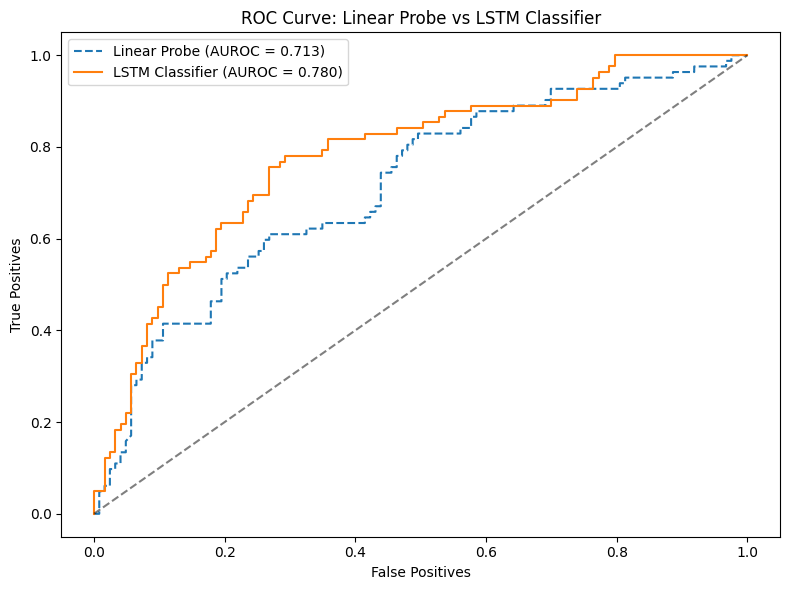

In [41]:
#Plot ROC curve for two classifiers for comparsion
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
test_best_layer = best_layer_over_thres[argmax_index]
with torch.no_grad():
    X_test_tensor = torch.tensor(embed_generated_test, dtype=torch.float32).cuda()
    X_test_flat = X_test_tensor[:, test_best_layer, :]  # e.g. best_layer = 22

    clf.eval()
    clf_scores = torch.sigmoid(clf(X_test_flat)).cpu().numpy()
    LSTM_scores = torch.sigmoid(LSTM_model(X_test_tensor)).cpu().numpy()

fpr_clf, tpr_clf, _ = roc_curve(gt_label_test, clf_scores)
fpr_lstm, tpr_lstm, _ = roc_curve(gt_label_test, LSTM_scores)

auc_clf = roc_auc_score(gt_label_test, clf_scores)
auc_lstm = roc_auc_score(gt_label_test, LSTM_scores)

print(f"Test dataset AUROC - Linear Probe: {auc_clf:.3f}")
print(f"Test dataset AUROC - LSTM Classifier: {auc_lstm:.3f}")

plt.figure(figsize=(8,6))
plt.plot(fpr_clf, tpr_clf, label=f"Linear Probe (AUROC = {auc_clf:.3f})", linestyle='--')
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM Classifier (AUROC = {auc_lstm:.3f})", linestyle='-')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.xlabel("False Positives")
plt.ylabel("True Positives")
plt.title("ROC Curve: Linear Probe vs LSTM Classifier")
plt.legend()
plt.tight_layout()
plt.show()

# Conclusion and Future Direction

This body of work successfully reproduced the Haloscope methodology. A linear probe classifier was trained using input data from the best-identified subspace projection of the last-token hidden state in the most effective transformer layer. This existing baseline was then compared to an LSTM-based classifier, where the full sequence of hidden states from all transformer layers was used as input. The results showed that the LSTM model performed comparably to the linear probe, while offering a significant reduction in training time — particularly given the linear probe’s additional overhead from PCA tuning across multiple layers and component sizes. This supports the hypothesis that an LSTM can effectively learn from internal representations of language models, and that layer depth may function analogously to temporal or sequential structure. To further investigate this hypothesis, future work could explore the generalizability of the LSTM model compared to the linear probe. Additionally, architectural elements such as self-attention could be incorporated to examine whether they improve the model’s ability to weight and interpret hidden state information during classification.

# References:

[1]:  Jie Ren, Jiaming Luo, Yao Zhao, Kundan Krishna, Mohammad Saleh, Balaji Lakshmi- narayanan, and Peter J Liu. Out-of-distribution detection and selective generation for con- ditional language models. In The Eleventh International Conference on Learning Representa- tions, 2023.

[2]:  Andrey Malinin and Mark Gales. Uncertainty estimation in autoregressive structured predic- tion. In International Conference on Learning Representations, 2021.

[3]:  Lorenz Kuhn, Yarin Gal, and Sebastian Farquhar. Semantic uncertainty: Linguistic invariances for uncertainty estimation in natural language generation. In International Conference on Learning Representations, 2023.

[4]:  Zhen Lin, Shubhendu Trivedi, and Jimeng Sun. Generating with confidence: Uncertainty quantification for black-box large language models. arXiv preprint arXiv:2305.19187, 2023.

[5]:  Potsawee Manakul, Adian Liusie, and Mark JF Gales. Selfcheckgpt: Zero-resource black- box hallucination detection for generative large language models. Proceedings of the 2023 Conference on Empirical Methods in Natural Language Processing, 2023.

[6]:  Chao Chen, Kai Liu, Ze Chen, Yi Gu, Yue Wu, Mingyuan Tao, Zhihang Fu, and Jieping Ye. Inside: Llms’ internal states retain the power of hallucination detection. In International Conference on Learning Representations, 2024.

[7]:  Stephanie Lin, Jacob Hilton, and Owain Evans. Teaching models to express their uncertainty in words. Transactions on Machine Learning Research, 2022.

[8]:  Saurav Kadavath, Tom Conerly, Amanda Askell, Tom Henighan, Dawn Drain, Ethan Perez, Nicholas Schiefer, Zac Hatfield-Dodds, Nova DasSarma, Eli Tran-Johnson, et al. Language models (mostly) know what they know. arXiv preprint arXiv:2207.05221, 2022.

[9]:  Collin Burns, Haotian Ye, Dan Klein, and Jacob Steinhardt. Discovering latent knowledge in language models without supervision. International Conference on Learning Representations, 2023.

[9]:  Collin Burns, Haotian Ye, Dan Klein, and Jacob Steinhardt. Discovering latent knowledge in language models without supervision. International Conference on Learning Representations, 2023.

[10]:  Xuefeng Du, Chaowei Xiao, and Yixuan Li. Haloscope: Harnessing unlabeled LLM generations for hallucination detection. In Advances in Neural Information Processing Systems, 2024.
